### Feature Engineering

Add these features:  "Mean"; "Std"; "Skewness"; "Kurtosis"; "Peak2Peak";
"RMS"; "CrestFactor"; "ShapeFactor"; "ImpulseFactor"; "MarginFactor"; "Energy";
"SKMean"; "SKStd"; "SKSkewness"; "SKKurtosis"

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import signal
from scipy.stats import skew, kurtosis

folder = "wind_turbine_pkl"

all_features = []

# make sure files are in order
files = sorted([f for f in os.listdir(folder) if f.startswith("wt_") and f.endswith(".pkl")])

for file in files:
    with open(os.path.join(folder, file), "rb") as f:
        data = pickle.load(f)

    # vibration signal
    v = np.array(data["vibration"])

    # Compute spectral kurtosis
    #f, sk = spectral_kurtosis(v, fs=97656, window_size=128)
    # Compute mean of spectral kurtosis across frequencies
    #sk_mean = np.mean(sk)

    features = {
        "Date": data["date"],
        "Mean": np.mean(v),
        "Std": np.std(v),
        "Skewness": skew(v),
        "Kurtosis": kurtosis(v, fisher=True, bias=False),
        "Peak2Peak": np.ptp(v),
        "RMS": np.sqrt(np.mean(v**2)),
        "CrestFactor": np.max(np.abs(v)) / np.sqrt(np.mean(v**2)),
        "ShapeFactor": np.sqrt(np.mean(v**2)) / np.mean(np.abs(v)),
        "ImpulseFactor": np.max(np.abs(v)) / np.mean(np.abs(v)),
        "MarginFactor": np.max(np.abs(v)) / (np.mean(np.abs(v))**2),
        "Energy": np.sum(v**2),
        #"SKMean": sk_mean,
        #"SKStd": np.std(sk),
        #"SKSkewness": skew(sk),
        #"SKKurtosis": kurtosis(sk, fisher=True, bias=False),
    }

    all_features.append(features)

# combine and save
features_df = pd.DataFrame(all_features)
features_df.to_csv("wt_bearing_features.csv", index=False)


In [2]:
features_df.head()

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy
0,2013-03-07 01:57:46,0.346052,2.270481,0.003870,-0.004378,21.621068,2.296702,4.914735,1.253517,6.160703,3.362451,3.090718e+06
1,2013-03-16 06:56:43,0.233177,1.984203,-0.001959,0.007185,18.831975,1.997857,5.048283,1.253975,6.330421,3.973352,2.338725e+06
2,2013-03-17 06:56:04,0.216575,2.113041,-0.001371,0.124720,21.857696,2.124111,5.485731,1.258684,6.904800,4.091575,2.643653e+06
3,2013-03-17 18:47:56,0.193808,2.133505,-0.012744,0.093440,21.588679,2.142290,5.319964,1.257507,6.689893,3.926914,2.689098e+06
4,2013-03-18 18:47:15,0.219193,2.128356,-0.000204,0.164703,24.050760,2.139613,5.788313,1.259477,7.290247,4.291382,2.682383e+06


Smooth the features with 5 day rolling average

In [3]:
# sort by date
features_df["Date"] = pd.to_datetime(features_df["Date"])
features_df = features_df.sort_values("Date").reset_index(drop=True)
features_df.head()

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy
0,2013-03-07 01:57:46,0.346052,2.270481,0.003870,-0.004378,21.621068,2.296702,4.914735,1.253517,6.160703,3.362451,3.090718e+06
1,2013-03-08 02:34:21,0.244092,2.062146,0.003010,0.019467,19.309907,2.076542,4.912863,1.254461,6.162997,3.723132,2.526572e+06
2,2013-03-09 02:33:43,0.218729,2.103553,-0.001029,0.022406,21.474075,2.114894,5.214330,1.253927,6.538388,3.876629,2.620761e+06
3,2013-03-10 03:01:02,0.213717,2.008063,0.001477,0.041467,19.520002,2.019404,5.286041,1.255580,6.637048,4.126636,2.389443e+06
4,2013-03-11 03:00:24,0.215185,2.060562,0.001012,0.044484,21.216959,2.071768,5.235226,1.255376,6.572174,3.982370,2.514967e+06


In [4]:

def smooth_data(data, window_size):
    result = np.zeros_like(data, dtype=float)
    
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        end_idx = i + 1  # being inclusive
        # get the mean
        result[i] = np.mean(data[start_idx:end_idx])
    
    return result

features_df_smooth = features_df.copy()

for col in features_df.columns:
    if col != "Date":
        features_df_smooth[col] = smooth_data(features_df[col].values, window_size=5)



In [5]:
features_df_smooth.to_csv("wt_bearing_features_smooth.csv", index=False)

plot what smoothing did

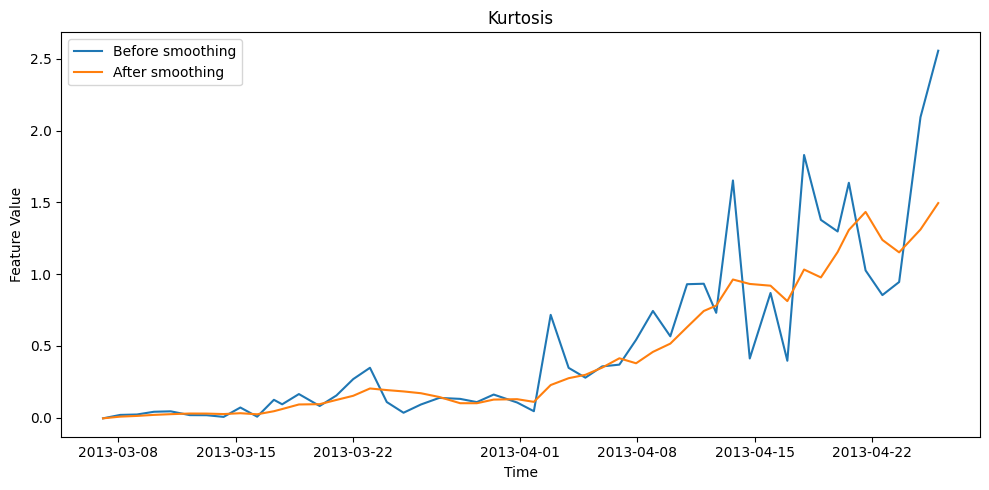

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(features_df["Date"], features_df["Kurtosis"], label="Before smoothing")
plt.plot(features_df_smooth["Date"], features_df_smooth["Kurtosis"], label="After smoothing")
plt.xlabel("Time")
plt.ylabel("Feature Value")
plt.title("Kurtosis")
plt.legend()
plt.tight_layout()
plt.show()


Get training data

In [7]:
from datetime import datetime

# 40% of data will be used for training, the cutoff date is March 27 2013
breaktime = datetime(2013, 3, 27)

features_df_smooth["Date"] = pd.to_datetime(features_df_smooth["Date"])
breakpoint = features_df_smooth[features_df_smooth["Date"] < breaktime].index.max()

train_data = features_df_smooth.loc[:breakpoint].copy()

Rank features based on monotonicity

In [8]:
# based off the equation mathworks shows
# mathworks writes that n is 50, that is all the data, not the training data, but they call
# the monotonicity with just training data so thats what I did 
# featureImportance = monotonicity(trainData, 'WindowSize', 0);
def monotonicity(train_data):

    monotonicity_scores = {}
    n = len(train_data)

    for col in train_data.columns:
        x = train_data[col].values
        diffs = np.diff(x)
        pos = np.sum(diffs > 0)
        neg = np.sum(diffs < 0)
        score = abs(pos - neg) / (n - 1)
        monotonicity_scores[col] = score
    
    return pd.Series(monotonicity_scores)

# get rid of date columns
numeric_train_data = train_data.select_dtypes(include=[np.number])

feature_importance = monotonicity(numeric_train_data)
print(feature_importance.sort_values(ascending=False))

MarginFactor     0.578947
Mean             0.368421
Kurtosis         0.368421
ShapeFactor      0.263158
Skewness         0.157895
ImpulseFactor    0.157895
Std              0.052632
Peak2Peak        0.052632
RMS              0.052632
CrestFactor      0.052632
Energy           0.052632
dtype: float64


In [9]:
# using only features with monotonicity score of over 0.3 like in mathworks
selected_features = feature_importance[feature_importance > 0.3].index.tolist()

# selecting those features
train_data_selected = train_data[['Date'] + selected_features]
feature_selected = features_df_smooth[['Date'] + selected_features]

In [10]:
import numpy as np
from sklearn.decomposition import PCA

X_train = train_data_selected.drop(columns='Date').values
X_full = feature_selected.drop(columns='Date').values

# normalize like its done in matworks
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
X_train_norm = (X_train - mean_train) / std_train

pca = PCA()
pca.fit(X_train_norm)
X_full_norm = (X_full - mean_train) / std_train

PCA1 = X_full_norm @ pca.components_[0]
PCA2 = X_full_norm @ pca.components_[1]


In [11]:
print(PCA1)

[-4.2861315  -2.65746193 -1.78687576 -1.1004394  -0.77805561 -0.40073904
 -0.20899307 -0.12128137  0.02724534 -0.10371231  0.6597995   0.89812628
  1.27503091  0.33603351  0.97855758  1.47915166  1.97117627  1.07915266
  1.73746083  1.00195545  0.2147054  -0.76000884  0.16282695  0.60507266
  0.7462306   1.31542883  3.47479598  3.25599164  3.2136615   3.85698196
  3.49547012  3.20683135  4.8035641   4.89672371  5.3222506   7.52738374
  6.80666876  7.85686066  8.04863065  8.35619693  6.66196578  9.75259663
  9.84723898 12.14455574 14.19665639 15.31090363 13.48406631 12.31082999
 12.13645092 12.7565749 ]


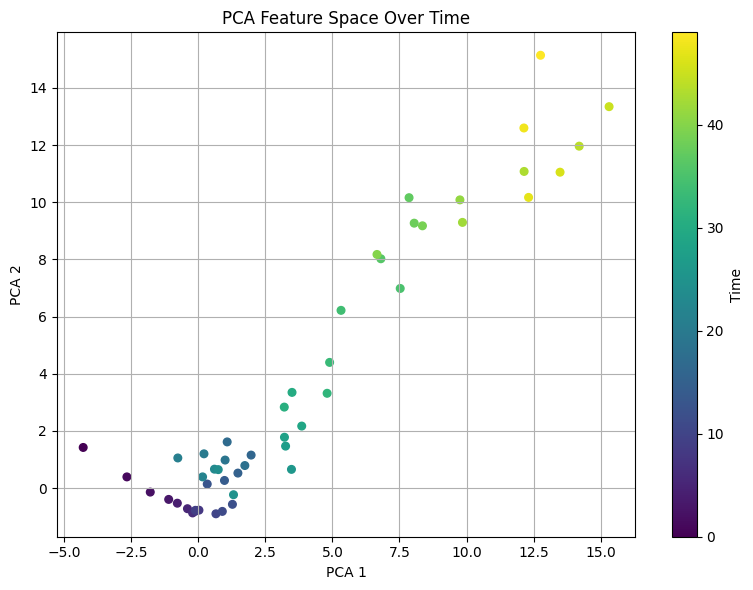

In [12]:
import matplotlib.pyplot as plt


num_data = len(PCA1)
color_vals = np.arange(num_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(PCA1, PCA2, c=color_vals, cmap='viridis', s=30)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Add colorbar with label
cbar = plt.colorbar(scatter)
cbar.set_label('Time')

plt.title('PCA Feature Space Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


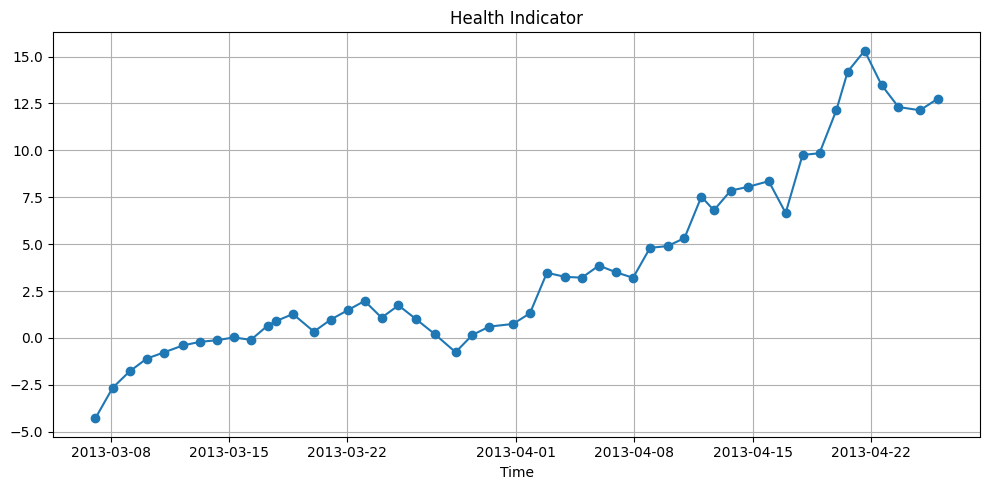

In [13]:
import matplotlib.pyplot as plt


PCAMat = '/Users/nechamab/Documents/MATLAB/Examples/R2025a/predmaint/WindTurbineHighSpeedBearingPrognosisExample/PCA_Results.csv'

health_indicator = PCA1

plt.figure(figsize=(10, 5))
plt.plot(feature_selected["Date"], health_indicator, marker='o', linestyle='-')
plt.xlabel("Time")
plt.title("Health Indicator")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
health_indicator_shifted = health_indicator - health_indicator[0]
threshold = health_indicator_shifted[-1]


Fitted Parameters:
  θ = 0.372995
  β = 0.076914


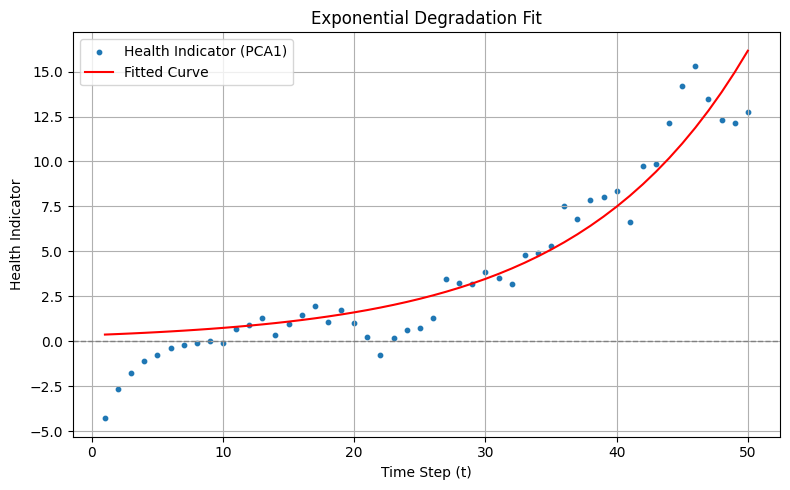

In [15]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

t = np.arange(1, len(health_indicator) + 1)

def degradation_model(t, theta, beta):
    return theta * (np.exp(beta * (t - 1)))

initial_guess = [1.0, -0.01]
params, _ = curve_fit(degradation_model, t, health_indicator, p0=initial_guess)
theta_fit, beta_fit = params

print("Fitted Parameters:")
print(f"  θ = {theta_fit:.6f}")
print(f"  β = {beta_fit:.6f}")

plt.figure(figsize=(8, 5))
plt.scatter(t, health_indicator, label="Health Indicator (PCA1)", s=10)
plt.plot(t, degradation_model(t, *params), color='red', label="Fitted Curve")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Exponential Degradation Fit")
plt.xlabel("Time Step (t)")
plt.ylabel("Health Indicator")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
